# Implementing the k-means and DBSCAN clustering algorithm from scratch and applying the implementation to new data

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.datasets

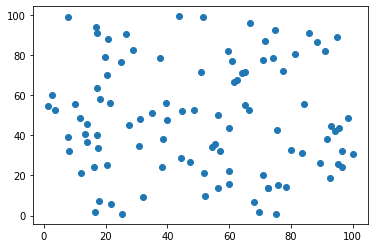

In [99]:
data = np.random.rand(100,2) * 100 # The dimensionality of the input doesn't matter.
plt.scatter(data[:,0], data[:,1])

## 1. k-means clustering

The K-means clustering algorithm will be implemented as follows:
1. Select k random points as the centroids of the new clusters.
2. Loop the following procedure:
    * Assign each point to the centroid that is the minimum Euclidean distance away from the point.
    * Calculate the centroid of the new cluster $\displaystyle \vec{C}_n = \frac{1}{N}\sum \vec{p}_n$, where $N$ is the number of points in the cluster.

In [100]:
class KMeans:
    def KPP_centroids(data, k):
        centroids = [data[np.random.choice(data.shape[0], 1, False)]]
        for i in range(k-1):
            dist = np.array([KMeans.min_centroid_dist(p, centroids)**2 for p in data])
            dist = dist/np.sum(dist)
            centroids.append(data[np.random.choice(data.shape[0], 1, p=dist)])
        return np.array(centroids)

    def min_centroid(pt, centroids):
        return np.argmin([np.linalg.norm(pt-ct) for ct in centroids])
    
    def min_centroid_dist(pt, centroids):
        return np.min([np.linalg.norm(pt-ct) for ct in centroids])

    def update_centroids(data, centroids):
        assign = [KMeans.min_centroid(p, centroids) for p in data]

        N = np.array([0 for _ in range(centroids.shape[0])])
        vec_sum = np.array([np.zeros(data.shape[1]) for _ in range(centroids.shape[0])])
        for pt in range(data.shape[0]):
            N[assign[pt]] += 1
            vec_sum[assign[pt]] += data[pt]
        centroids = np.array([vec/n for vec, n in zip(vec_sum, N)])
        return centroids, assign

    def k_means(data, k, reps=1000, min_dist=None):
        if(reps != None):
            centroids = KMeans.KPP_centroids(data, k)
            for i in range(reps):
                centroids, assign = KMeans.update_centroids(data, centroids)
        elif(min_dist != None):
            old_centroids = KMeans.KPP_centroids(data, k)
            centroids, _ = KMeans.update_centroids(data, old_centroids)
            while(np.min(np.abs(centroids-old_centroids)) > min_dist):
                old_centroids = centroids
                centroids, assign = KMeans.update_centroids(data, old_centroids)

        return centroids, assign

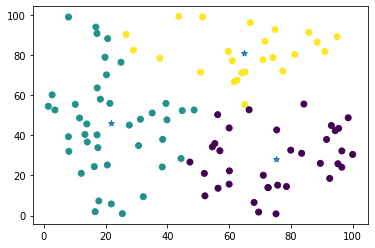

In [101]:
centroids, category = KMeans.k_means(data, 3, reps=100, min_dist=None)
plt.scatter(data[:,0], data[:,1], c=category)
plt.scatter(centroids[:,0], centroids[:,1], marker="*")

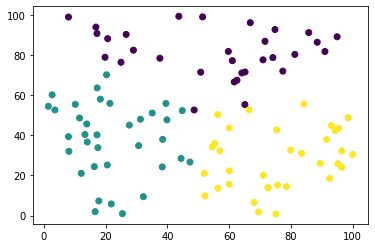

In [102]:
kmeans_model = sklearn.cluster.KMeans(3, init="k-means++", max_iter=100, tol=0).fit(data)
plt.scatter(data[:,0], data[:,1], c=kmeans_model.labels_)

## 2. DBSCAN clustering

The algorithm will be implemented as follows:
0. Given hyperparameters $\epsilon$ (minimum distance) and $N$ (minimum neighbors)...
1. Select a random point in the dataset.
2. Find all points in the dataset which are within $\epsilon$ distance from the original point.
3. If the number of points is greater than $N$...
    - Give the point a new unique label
    - For each of the neighboring points that do NOT already have a label...
        - Run the DBSCAN algorithm on that point.
4. Else, mark the point as noise and choose another random point.

In [107]:
class DBSCAN:                
    def distance(p1, p2):
        return np.linalg.norm(p2-p1)
        
    def DBSCAN_rec(data, labels, pt, epsilon, N, ts=None):
        if(labels[pt] > 0):
            return labels
        
        if(ts != None): # Only set as a new cluster if not designated as a border point
            labels[pt] = ts
        else:
            labels[pt] = max(labels) + 1
            
        close = [DBSCAN.distance(data[pt], x) <= epsilon for x in data]
        if(sum(close) >= N):
            for i in range(data.shape[0]):
                if(close[i] and i != pt):
                    labels = DBSCAN.DBSCAN_rec(data, labels, i, epsilon, N, ts=labels[pt]) # If this happens, the new point is not an outlier/in a new cluster!

        else:
            if(ts == None): # Only set as an outlier if not designated as a border point
                labels[pt] = -1
        
        return labels
        
                    
    def DBSCAN(data, epsilon, N):
        labels = [0 for _ in range(data.shape[0])]
        
        order_of_visit = np.arange(data.shape[0]) # To make order of point visiting completely random
        np.random.shuffle(order_of_visit)
        
        for pt in order_of_visit:
            labels = DBSCAN.DBSCAN_rec(data, labels, pt, epsilon, N) # defaults to ts=None
        
        return labels

[-1, 1, 9, -1, 4, 7, 9, 10, 1, 10, 10, 7, 4, 6, 1, 3, 1, 1, 2, 3, 10, 5, 6, -1, 10, 8, 1, 5, 3, 1, 2, 1, 3, 4, 10, 1, 10, 1, 9, 1, -1, 1, 10, 4, 4, 3, 1, 7, 3, 8, 7, 10, 10, 3, 8, 3, 3, 1, 10, 1, 6, -1, 5, 3, 4, 4, -1, 6, 5, 6, -1, 6, 3, 1, 7, 3, 1, 10, -1, -1, -1, 7, 1, 1, 3, 6, 1, 6, 1, 6, -1, 7, 1, 7, 2, 10, -1, 2, 4, 1]


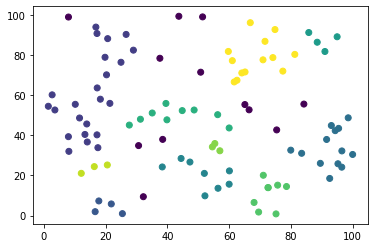

In [108]:
labels = DBSCAN.DBSCAN(data, 9, 3) # eps=9, min_samples=3 (including self)
print(labels)

plt.scatter(data[:,0], data[:,1], c=labels)

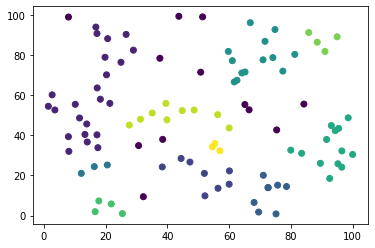

In [109]:
dbscan_labels = sklearn.cluster.DBSCAN(eps=9, min_samples=3).fit(data).labels_
plt.scatter(data[:,0], data[:,1], c=dbscan_labels)

Note that the two outputs for my own implementation and the official sklearn implementation are identical.

# 3. Applying my implementation to new datasets

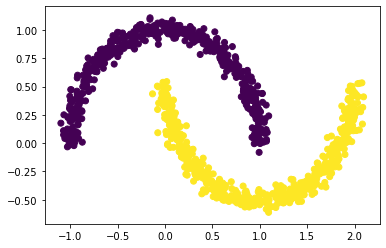

In [114]:
moons_data, moons_labels = sklearn.datasets.make_moons(n_samples=1000, noise=.05)
plt.scatter(moons_data[:,0], moons_data[:,1], c=moons_labels)

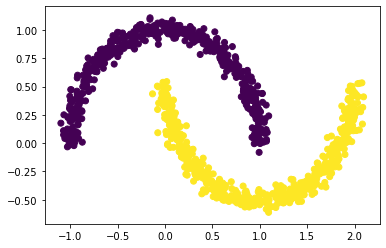

In [119]:
DBSCAN_moons_labels = DBSCAN.DBSCAN(moons_data, 0.1, 5)
plt.scatter(moons_data[:,0], moons_data[:,1], c=DBSCAN_moons_labels)

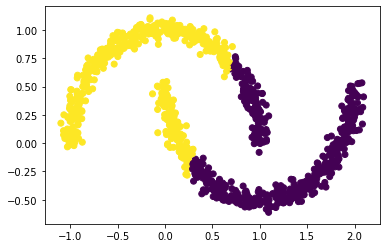

In [122]:
_, KMeans_moons_labels = KMeans.k_means(moons_data, 2, reps=None, min_dist=1e-4)
plt.scatter(moons_data[:,0], moons_data[:,1], c=KMeans_moons_labels)